<a href="https://colab.research.google.com/github/matheusfigueiredoo/detection-of-cyber-attacks/blob/main/multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras==2.12.0
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.
Mounted at /content/drive


In [2]:
train = pd.read_csv("drive/MyDrive/MQTTset/train70_augmented.csv")
test = pd.read_csv("drive/MyDrive/MQTTset/test30_augmented.csv")
train = pd.DataFrame(train)
test = pd.DataFrame(test)

# distribuição das targets
print(train['target'].value_counts())
print(test['target'].value_counts())

target
legitimate    7000000
bruteforce    1400000
flood         1400000
slowite       1400000
dos           1400000
malformed     1400000
Name: count, dtype: int64
target
legitimate    3000000
dos            600000
slowite        600000
flood          600000
bruteforce     600000
malformed      600000
Name: count, dtype: int64


In [3]:
# balanceamento dos dados
# rows é a variável que recebe o índice das linhas que serão deletadas para o balanceamento dos dados
rows_train = []

# dados de treinamento
for i in train.index:
    if train['target'][i] == 'legitimate':
        rows_train.append(i)
rows_train = rows_train[:5600000]  # diferença para balancear os dados
train = train.drop(rows_train)

# dados de teste
rows_test = []
for i in test.index:
    if test['target'][i] == 'legitimate':
        rows_test.append(i)
rows_test = rows_test[:2400000]
test = test.drop(rows_test)

# nova distribuição de dados
print(train['target'].value_counts())
print(test['target'].value_counts())

target
bruteforce    1400000
flood         1400000
slowite       1400000
dos           1400000
malformed     1400000
legitimate    1400000
Name: count, dtype: int64
target
dos           600000
slowite       600000
flood         600000
bruteforce    600000
malformed     600000
legitimate    600000
Name: count, dtype: int64


In [4]:
# pre processamento de dados
# separacao de features e targets

X_train = train.iloc[:,:-1]
y_train = train['target']
X_test = test.iloc[:,:-1]
y_test = test['target']

In [5]:
# transformacao de features e targets categoricas em numeros inteiros

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

# targets
label.fit(y_train)
label.fit(y_test)

print(y_train)
print(y_test)

1           bruteforce
2                flood
3              slowite
4                flood
7           bruteforce
               ...    
13999995    legitimate
13999996       slowite
13999997       slowite
13999998    legitimate
13999999     malformed
Name: target, Length: 8400000, dtype: object
0                 dos
2             slowite
3               flood
4             slowite
5               flood
              ...    
5999995         flood
5999996    legitimate
5999997    legitimate
5999998    bruteforce
5999999    legitimate
Name: target, Length: 3600000, dtype: object


In [6]:
label.classes_     # ordem das classes

array(['bruteforce', 'dos', 'flood', 'legitimate', 'malformed', 'slowite'],
      dtype=object)

In [7]:
y_train = label.transform(y_train)
y_test = label.transform(y_test)
print(y_train)
print(y_test)

[0 2 5 ... 5 3 4]
[1 5 2 ... 3 0 3]


In [8]:
# features
X_train['tcp.flags'] = label.fit_transform(X_train['tcp.flags'])
X_train['mqtt.conack.flags'] = label.fit_transform(X_train['mqtt.conack.flags'])
X_train['mqtt.hdrflags'] = label.fit_transform(X_train['mqtt.hdrflags'])
X_train['mqtt.protoname'] = label.fit_transform(X_train['mqtt.protoname'])
X_train['mqtt.msg'] = label.fit_transform(X_train['mqtt.msg'])
X_train['mqtt.conflags'] = label.fit_transform(X_train['mqtt.conflags'])

X_test['tcp.flags'] = label.fit_transform(X_test['tcp.flags'])
X_test['mqtt.conack.flags'] = label.fit_transform(X_test['mqtt.conack.flags'])
X_test['mqtt.hdrflags'] = label.fit_transform(X_test['mqtt.hdrflags'])
X_test['mqtt.protoname'] = label.fit_transform(X_test['mqtt.protoname'])
X_test['mqtt.msg'] = label.fit_transform(X_test['mqtt.msg'])
X_test['mqtt.conflags'] = label.fit_transform(X_test['mqtt.conflags'])

In [9]:
# ajuste de dados
# columns_0 são as colunas com dados iguais a 0

columns_0 = ['mqtt.conack.flags.reserved', 'mqtt.conack.flags.sp', 'mqtt.conflag.qos',
           'mqtt.conflag.reserved', 'mqtt.conflag.retain', 'mqtt.conflag.willflag',
           'mqtt.retain', 'mqtt.sub.qos', 'mqtt.suback.qos', 'mqtt.willmsg', 'mqtt.willmsg_len',
           'mqtt.willtopic', 'mqtt.willtopic_len']
X_train = X_train.drop(columns_0, axis=1)
X_test = X_test.drop(columns_0, axis=1)

print(X_train.shape)
print(X_test.shape)

(8400000, 20)
(3600000, 20)


In [10]:
X_train = X_train.values
X_test = X_test.values

print(type(X_train))
print(type(X_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [16]:
# treinamento de dados

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Accuracy train:  0.8796972619047619
Accuracy test:  0.8799933333333333 

Tabela de desempenho: 
              precision    recall  f1-score   support

           0       0.78      0.88      0.83    600000
           1       0.91      0.89      0.90    600000
           2       0.87      0.88      0.88    600000
           3       0.85      0.90      0.88    600000
           4       0.89      0.72      0.80    600000
           5       1.00      1.00      1.00    600000

    accuracy                           0.88   3600000
   macro avg       0.88      0.88      0.88   3600000
weighted avg       0.88      0.88      0.88   3600000
 

Matriz de confusão:
[[529903  25805   1197    472  42623      0]
 [  7783 533384  20553  27780  10500      0]
 [  1200   4800 529200  63600   1200      0]
 [    58   8568  50257 540549    568      0]
 [141420  15960   5640   2040 434940      0]
 [     0      0      0      0      0 600000]] 



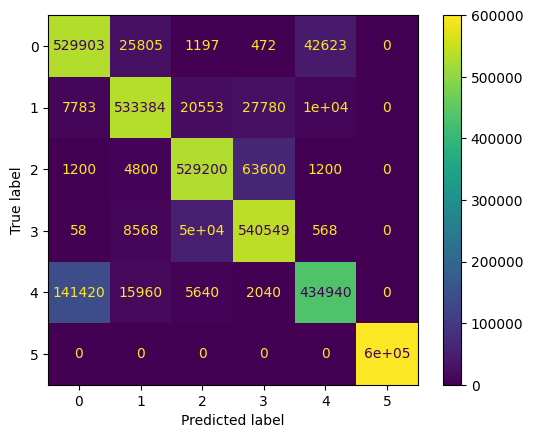

In [ ]:
# decision tree

tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None)
tree.fit(X_train, y_train)
print("Accuracy train: ", tree.score(X_train, y_train))
print("Accuracy test: ", tree.score(X_test, y_test), "\n")

# predição de valores
predict_tree = tree.predict(X_test)
print("Tabela de desempenho: ")
print(classification_report(y_test, predict_tree), "\n")

# confusion matrix
matrix_tree = confusion_matrix(y_test, predict_tree)
print("Matriz de confusão:")
print(matrix_tree, "\n")
cm_tree = confusion_matrix(y_test, predict_tree, labels=tree.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=tree.classes_)
disp_tree.plot()
plt.show()

Accuracy train:  0.8796972619047619
Accuracy test:  0.8800322222222222 

Tabela de desempenho: 
              precision    recall  f1-score   support

           0       0.78      0.88      0.83    600000
           1       0.91      0.89      0.90    600000
           2       0.87      0.88      0.88    600000
           3       0.85      0.90      0.88    600000
           4       0.89      0.72      0.80    600000
           5       1.00      1.00      1.00    600000

    accuracy                           0.88   3600000
   macro avg       0.88      0.88      0.88   3600000
weighted avg       0.88      0.88      0.88   3600000
 

Matriz de confusão:
[[529903  25805   1197    472  42623      0]
 [  7783 533384  20553  27780  10500      0]
 [  1200   4800 529200  63600   1200      0]
 [    58   8568  50257 540689    428      0]
 [141420  15960   5640   2040 434940      0]
 [     0      0      0      0      0 600000]] 



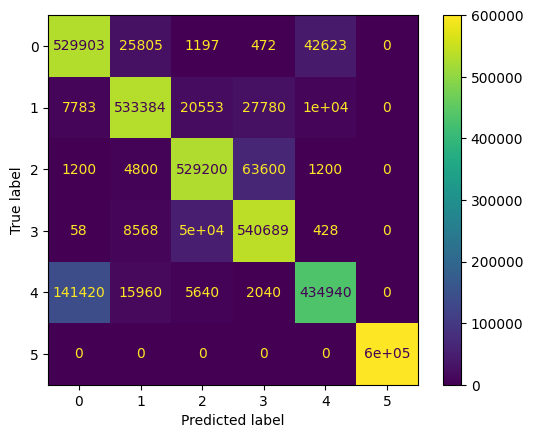

In [ ]:
# random forest

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print("Accuracy train: ", rf.score(X_train, y_train))
print("Accuracy test: ", rf.score(X_test, y_test), "\n")

# predição de valores
predict_rf = rf.predict(X_test)
print("Tabela de desempenho: ")
print(classification_report(y_test, predict_rf), "\n")

# confusion matrix
matrix_rf = confusion_matrix(y_test, predict_rf)
print("Matriz de confusão:")
print(matrix_rf, "\n")
cm_rf = confusion_matrix(y_test, predict_rf, labels=rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
disp_rf.plot()
plt.show()

Accuracy train:  0.5298226190476191
Accuracy test:  0.5297875 

Tabela de desempenho: 
              precision    recall  f1-score   support

           0       0.28      1.00      0.44    600000
           1       0.96      0.72      0.82    600000
           2       0.98      0.49      0.65    600000
           3       0.76      0.62      0.68    600000
           4       1.00      0.15      0.26    600000
           5       0.98      0.21      0.34    600000

    accuracy                           0.53   3600000
   macro avg       0.83      0.53      0.53   3600000
weighted avg       0.83      0.53      0.53   3600000
 

Matriz de confusão:
[[600000      0      0      0      0      0]
 [169519 430130      0    206    145      0]
 [303600      0 292800   3600      0      0]
 [222406      0   4714 372880      0      0]
 [439260  17280   1620  51420  88200   2220]
 [415575      0      0  61200      0 123225]] 



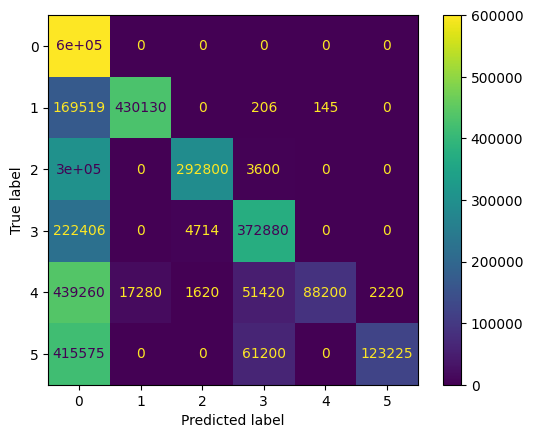

In [ ]:
# naive bayes

nb = GaussianNB()
nb.fit(X_train, y_train)
print("Accuracy train: ", nb.score(X_train, y_train))
print("Accuracy test: ", nb.score(X_test, y_test), "\n")

# predição de valores
predict_nb = nb.predict(X_test)
print("Tabela de desempenho: ")
print(classification_report(y_test, predict_nb), "\n")

# confusion matrix
matrix_nb = confusion_matrix(y_test, predict_nb)
print("Matriz de confusão:")
print(matrix_nb, "\n")
cm_nb = confusion_matrix(y_test, predict_nb, labels=nb.classes_)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=nb.classes_)
disp_nb.plot()
plt.show()

Accuracy train:  0.8644736904761905
Accuracy test:  0.8648011111111111 

Tabela de desempenho: 
              precision    recall  f1-score   support

           0       0.72      0.88      0.80    600000
           1       0.90      0.89      0.90    600000
           2       0.87      0.88      0.88    600000
           3       0.85      0.90      0.88    600000
           4       0.87      0.64      0.74    600000
           5       1.00      1.00      1.00    600000

    accuracy                           0.86   3600000
   macro avg       0.87      0.86      0.86   3600000
weighted avg       0.87      0.86      0.86   3600000
 

Matriz de confusão:
[[530875  26231   1883    472  40539      0]
 [  9859 532604  19177  27780  10580      0]
 [  1200   4800 526800  63600   3600      0]
 [    80   8635  50681 540145    459      0]
 [192300  17760   5040   2040 382860      0]
 [     0      0      0      0      0 600000]] 



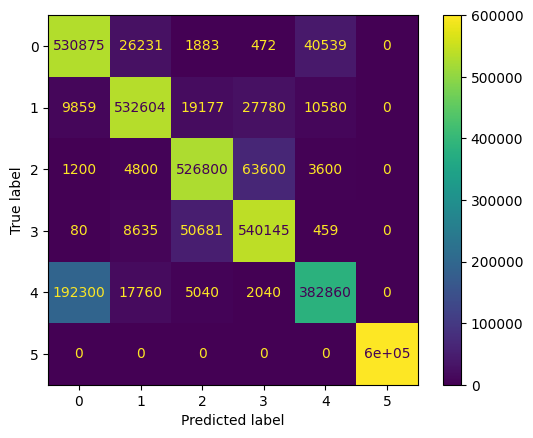

In [12]:
# gradient boosting

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
print("Accuracy train: ", gb.score(X_train, y_train))
print("Accuracy test: ", gb.score(X_test, y_test), "\n")

# predição de valores
predict_gb = gb.predict(X_test)
print("Tabela de desempenho: ")
print(classification_report(y_test, predict_gb), "\n")

# confusion matrix
matrix_gb = confusion_matrix(y_test, predict_gb)
print("Matriz de confusão:")
print(matrix_gb, "\n")
cm_gb = confusion_matrix(y_test, predict_gb, labels=gb.classes_)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=gb.classes_)
disp_gb.plot()
plt.show()

Accuracy train:  0.798897261904762
Accuracy test:  0.7988788888888889 

Tabela de desempenho: 
              precision    recall  f1-score   support

           0       0.67      0.92      0.77    600000
           1       1.00      0.72      0.84    600000
           2       0.58      0.99      0.73    600000
           3       0.99      0.63      0.77    600000
           4       0.94      0.54      0.69    600000
           5       1.00      1.00      1.00    600000

    accuracy                           0.80   3600000
   macro avg       0.86      0.80      0.80   3600000
weighted avg       0.86      0.80      0.80   3600000
 

Matriz de confusão:
[[550690      0  28970      0  20340      0]
 [ 18627 430386 150887      0    100      0]
 [  4800      0 591600   2400   1200      0]
 [   419      0 221905 377608     68      0]
 [247920      0  26400      0 325680      0]
 [     0      0      0      0      0 600000]] 



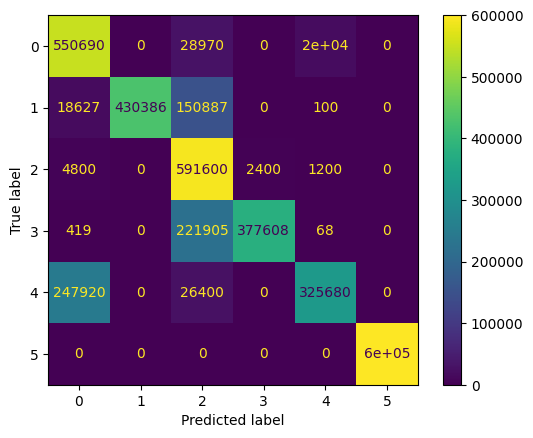

In [13]:
# multi-layer perceptron

mlp = MLPClassifier()
mlp.fit(X_train, y_train)
print("Accuracy train: ", mlp.score(X_train, y_train))
print("Accuracy test: ", mlp.score(X_test, y_test), "\n")

# predição de valores
predict_mlp = mlp.predict(X_test)
print("Tabela de desempenho: ")
print(classification_report(y_test, predict_mlp), "\n")

# confusion matrix
matrix_mlp = confusion_matrix(y_test, predict_mlp)
print("Matriz de confusão:")
print(matrix_mlp, "\n")
cm_mlp = confusion_matrix(y_test, predict_mlp, labels=mlp.classes_)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=mlp.classes_)
disp_mlp.plot()
plt.show()

Epoch 1/200
8400/8400 - 24s - loss: 0.6301 - accuracy: 0.7241 - val_loss: 0.5620 - val_accuracy: 0.7392 - 24s/epoch - 3ms/step
Epoch 2/200
8400/8400 - 22s - loss: 0.5586 - accuracy: 0.7383 - val_loss: 0.5538 - val_accuracy: 0.7396 - 22s/epoch - 3ms/step
Epoch 3/200
8400/8400 - 22s - loss: 0.5551 - accuracy: 0.7444 - val_loss: 0.5444 - val_accuracy: 0.7420 - 22s/epoch - 3ms/step
Epoch 4/200
8400/8400 - 22s - loss: 0.5281 - accuracy: 0.7575 - val_loss: 0.5083 - val_accuracy: 0.7573 - 22s/epoch - 3ms/step
Epoch 5/200
8400/8400 - 23s - loss: 0.5033 - accuracy: 0.7702 - val_loss: 0.4791 - val_accuracy: 0.7922 - 23s/epoch - 3ms/step
Epoch 6/200
8400/8400 - 23s - loss: 0.4608 - accuracy: 0.7896 - val_loss: 0.4327 - val_accuracy: 0.7958 - 23s/epoch - 3ms/step
Epoch 7/200
8400/8400 - 22s - loss: 0.4766 - accuracy: 0.7885 - val_loss: 0.4953 - val_accuracy: 0.7684 - 22s/epoch - 3ms/step
Epoch 8/200
8400/8400 - 23s - loss: 0.4960 - accuracy: 0.7669 - val_loss: 0.4912 - val_accuracy: 0.7696 - 23s/e

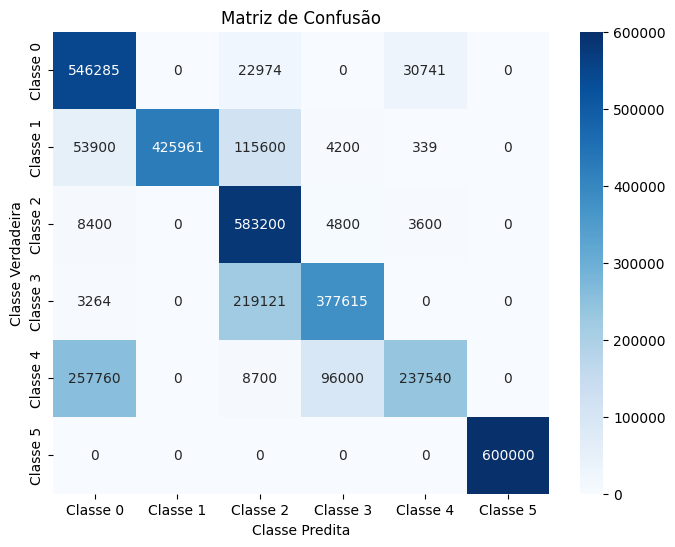

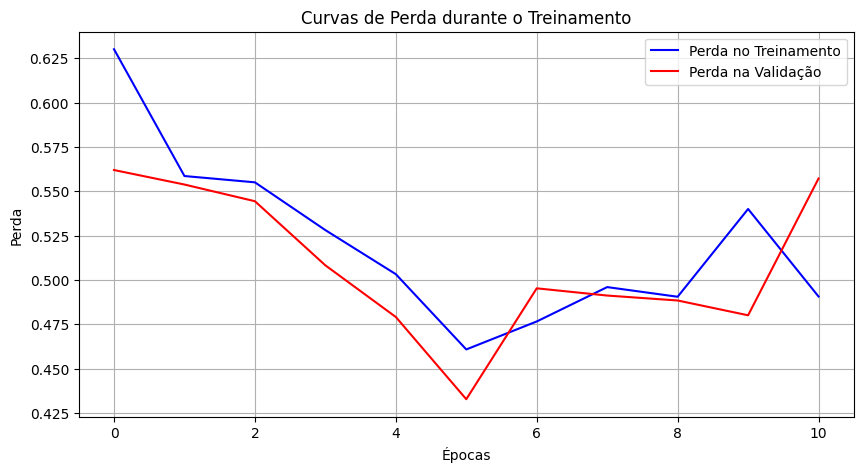

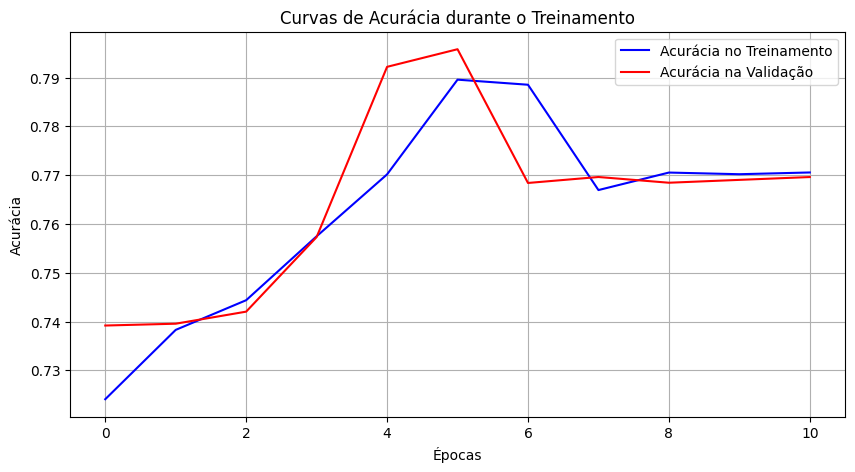

In [14]:
# sequential neural network

model = Sequential()
model.add(Dense(50, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(30, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(20, kernel_initializer='normal'))
model.add(Dense(6,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks=[monitor],verbose=2,epochs=200,batch_size=1000)

# matriz de confusão
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix, "\n")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Classe ' + str(i) for i in range(conf_matrix.shape[0])],
            yticklabels=['Classe ' + str(i) for i in range(conf_matrix.shape[0])])
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

print("\n")

# valores de perda e acurácia durante o treinamento
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# curvas de perda
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Perda no Treinamento', color='blue')
plt.plot(val_loss, label='Perda na Validação', color='red')
plt.title('Curvas de Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.show()
print("\n")

# curvas de acurácia
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Acurácia no Treinamento', color='blue')
plt.plot(val_accuracy, label='Acurácia na Validação', color='red')
plt.title('Curvas de Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy, "\n")
print("Tabela de desempenho:")
print(classification_report(y_test, y_pred))

112500/112500 [==============================] - 105s 931us/step
Acurácia: 0.7696113888888889 

Tabela de desempenho:
              precision    recall  f1-score   support

           0       0.63      0.91      0.74    600000
           1       1.00      0.71      0.83    600000
           2       0.61      0.97      0.75    600000
           3       0.78      0.63      0.70    600000
           4       0.87      0.40      0.54    600000
           5       1.00      1.00      1.00    600000

    accuracy                           0.77   3600000
   macro avg       0.82      0.77      0.76   3600000
weighted avg       0.82      0.77      0.76   3600000

